In [76]:
# import libraries used throughout the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn import svm, metrics, pipeline, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

In [77]:
#check version
sklearn.__version__

'1.5.0'

The dataset we use is from the paper <a href="https://www.researchgate.net/publication/228780408_Using_data_mining_to_predict_secondary_school_student_performance">Using data mining to predict secondary school student performance</a> by Paulo Cortez and Alice Silva.

In [78]:
data = pd.read_csv('data/student-por.csv', delimiter=';')
# heatmap requires numerical values
data = data.replace(to_replace=['M', 'F'], value=[0,1]) #sex
data = data.replace(to_replace=['GP', 'MS'], value=[0,1]) #school
data = data.replace(to_replace=['A', 'T'], value=[0,1]) #Pstatus
data = data.replace(to_replace=['GT3', 'LE3'], value=[0,1]) #famsize
data = data.replace(to_replace=['U', 'R'], value=[0,1]) #address
data = data.replace(to_replace=['father', 'mother'], value=[0,1]) #guardian
data = data.replace(to_replace=['at_home', 'health', 'other', 'services', 'teacher'], value=[0,1,2,3,4]) #Mjob, Fjob
data = data.replace(to_replace=['course', 'other', 'home', 'reputation'], value=[0,1,2,3]) #reason
data = data.replace(to_replace=['no', 'yes'], value=[0,1]) #fatherd, nursery, higher, famsup, romantic
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,18,0,0,0,4,4,0,4,...,4,3,4,1,1,3,4,0,11,11
1,0,1,17,0,0,1,1,1,0,2,...,5,3,3,1,1,3,2,9,11,11
2,0,1,15,0,1,1,1,1,0,2,...,4,3,2,2,3,3,6,12,13,12
3,0,1,15,0,0,1,4,2,1,3,...,3,2,2,1,1,5,0,14,14,14
4,0,1,16,0,0,1,3,3,2,2,...,4,3,2,1,2,5,0,11,13,13


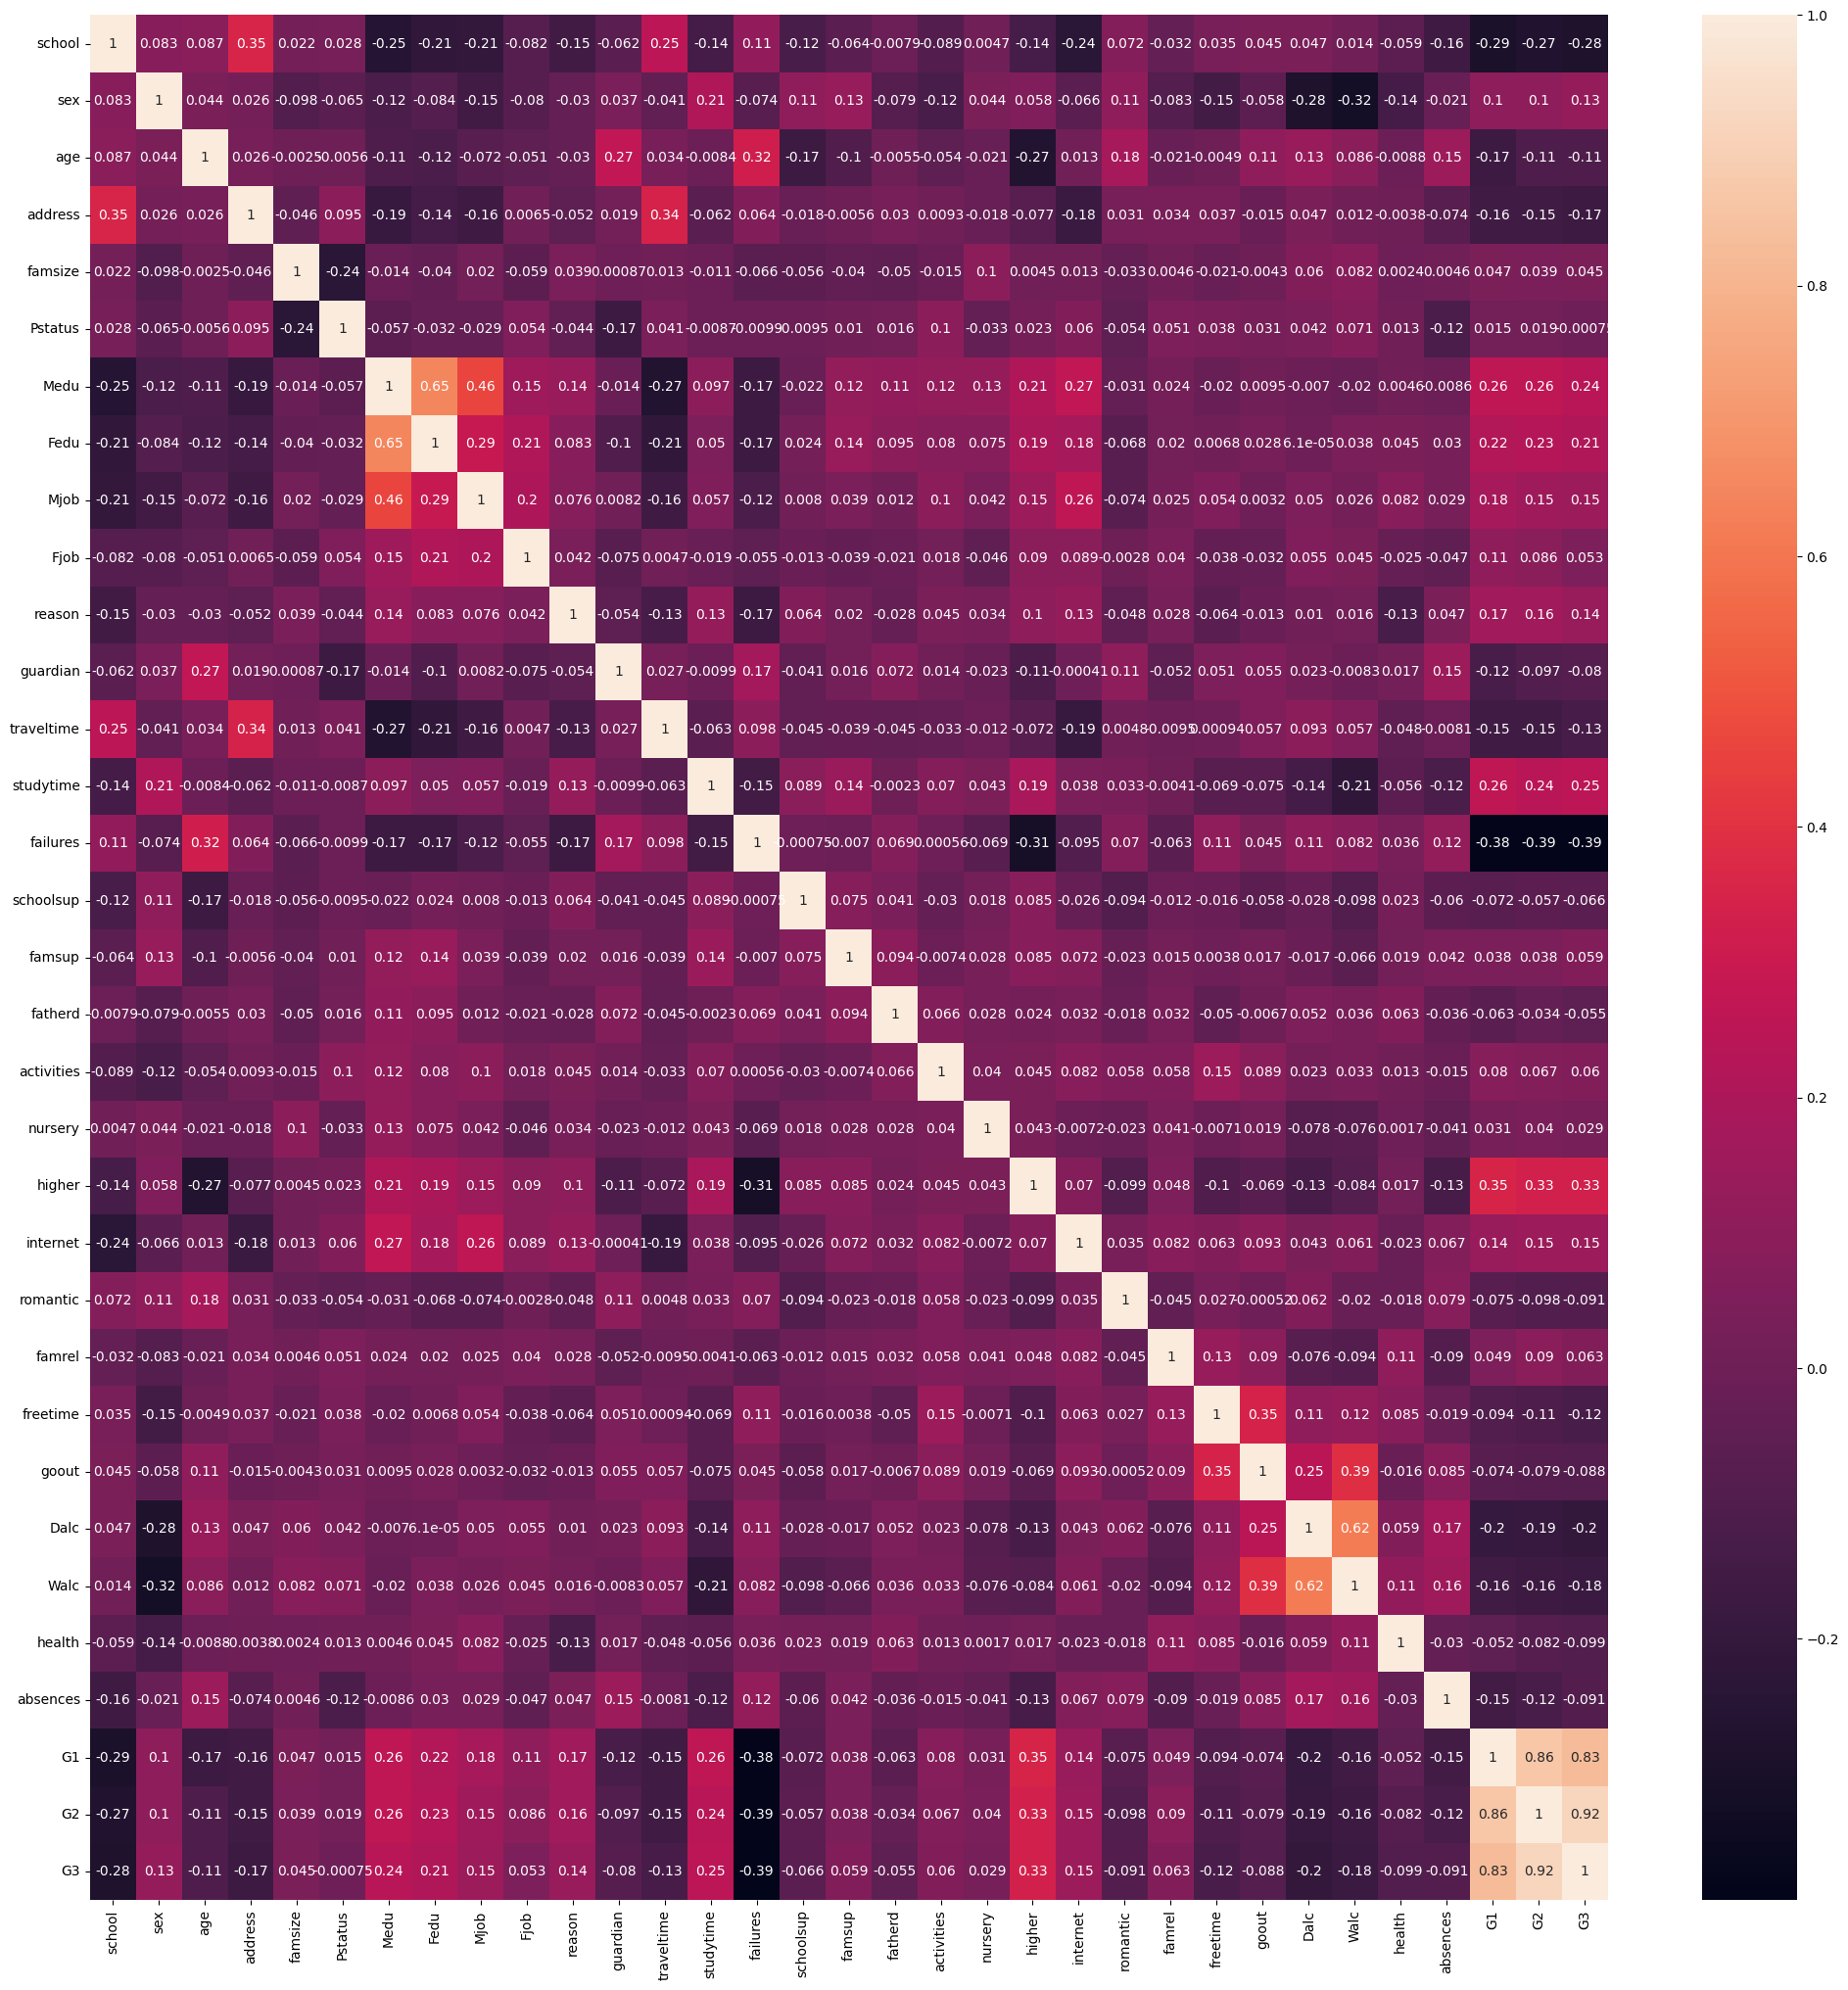

In [79]:
# add correlation matrix to see which features are highly correlated
corr_data = data.select_dtypes(include='number')
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(corr, annot=True)

# features highly correlated with sex: Dalc(-), Walc(-), studytime, freetime(-), Mjob(-), health(-), G3, famsup, Medu(-), romantic

In [98]:
# split data for training and testing (80:20), use all features except predictor and sensitive attribute
features = data.drop(columns=['G3', 'sex'])
X = features
y = data['G3'] # predict final grade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# binary classifier: pass if >= 10, else fail

# redefine values for binary classification
y_train_binary = y_train.tolist()
y_test_binary = y_test.tolist()
for i in range(len(y_train_binary)):
    if y_train_binary[i] >= 10:
        y_train_binary[i] = 1
    else:
        y_train_binary[i] = 0
for i in range(len(y_test_binary)):
    if y_test_binary[i] >= 10:
        y_test_binary[i] = 1
    else:
        y_test_binary[i] = 0

# we use SVM, paper tried 5 different models
clf = svm.SVC().fit(X_train, y_train_binary)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test_binary, pred) # 93.1% accuracy

0.9307692307692308

In [101]:
# 5 level classification as defined in paper
y_train_5 = y_train.replace(to_replace=[[20, 19, 18, 17, 16], [15, 14], [13, 12], [11, 10], [9,8,7,6,5,4,3,2,1]], value=[1, 2, 3, 4, 5])
y_test_5 = y_test.replace(to_replace=[[20, 19, 18, 17, 16], [15, 14], [13, 12], [11, 10], [9,8,7,6,5,4,3,2,1]], value=[1, 2, 3, 4, 5])
clf = svm.SVC().fit(X_train, y_train_5)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test_5, pred) # 70% accuracy

0.7

In [102]:
# regression: score determined by RMSE

regr = svm.SVR().fit(X_train, y_train)
pred = regr.predict(X_test)
metrics.mean_squared_error(y_test, pred) # 1.70

1.6980659535368896

In [107]:
# classification: try to predict sensitive attribute (sex) using highly correlated features
features = data[['Dalc', 'Walc', 'studytime', 'freetime']]
X = features
y = data['sex']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC().fit(X_train, y_train)
pred = clf.predict(X_test)
metrics.accuracy_score(y_test, pred) # 75.4% accuracy

0.7538461538461538